# Préparation pour la classification mutliclass

In [1]:
import pandas as pd
from test import convertCatToNum, drop_rows_with_missing, normalize, encode_player_names, split_data
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib as plt
import time

# on import toutes les données

df_atp_multi = pd.read_csv('all_matches_ATP_multi.csv')

In [2]:
df_atp_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37861 entries, 0 to 37860
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         37861 non-null  int64  
 1   Court       37861 non-null  object 
 2   Surface     37861 non-null  object 
 3   Round       37861 non-null  object 
 4   Best of     37861 non-null  float64
 5   WRank       37861 non-null  int64  
 6   LRank       37861 non-null  int64  
 7   Comment     37861 non-null  object 
 8   PSW         37861 non-null  float64
 9   PSL         37861 non-null  float64
 10  B365W       37861 non-null  float64
 11  B365L       37861 non-null  float64
 12  Series      27456 non-null  float64
 13  y_multicat  37861 non-null  int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 4.0+ MB


In [3]:
df_atp_multi.head(2)

,ATP,Court,Surface,Round,Best of,WRank,LRank,Comment,PSW,PSL,B365W,B365L,Series,y_multicat
0,3,Outdoor,Hard,1st Round,3.0,52,96,Completed,2.060,1.82,2.100,1.667,NaN,0
1,2,Outdoor,Hard,1st Round,3.0,92,99,Completed,1.455,2.90,1.444,2.625,NaN,1


In [4]:
cat_cols = ['Court','Surface','Round','Comment']
num_cols = ["PSW","PSL","Best of","B365W","B365L","Series"]

In [5]:
df_processed = convertCatToNum(df=df_atp_multi,cat_cols=cat_cols)
df = drop_rows_with_missing(df_processed,columns=["y_multicat","Series"])
df_final = normalize(df,num_cols)

 ===     Replace categorial variable     ===


 ===   Convert categorical to numerical  ===
 ===         drop missing values         ===
 ===            Normalize data           ===


KeyError: 'Lsets'

In [ ]:
df_final.head()

,ATP,Best of,WRank,LRank,Lsets,PSW,PSL,B365W,B365L,Series,...,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,Comment_Completed,Comment_Retired
53,6,1.0,28,111,0.0,0.006143,0.032836,0.007591,0.034903,1.000000,...,1,0,0,0,0,0,0,0,0,1
942,67,0.0,1,10,0.0,0.002857,0.060338,0.002864,0.069907,0.714286,...,0,0,0,0,0,1,0,0,1,0
943,67,0.0,3,5,1.0,0.009229,0.022002,0.015136,0.022402,0.714286,...,0,0,0,0,0,1,0,0,1,0
944,67,0.0,5,10,0.0,0.011657,0.017418,0.015136,0.022402,0.714286,...,0,0,0,0,0,1,0,0,1,0
945,67,0.0,7,6,0.0,0.008943,0.022752,0.013636,0.023902,0.714286,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = split_data(df_final,target_column='y_multicat', test_size=0.2, random_state=42)

=== Splitting data into train and test sets ===
Data split completed.


In [ ]:
X_train.shape

(21964, 26)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define model
model = DecisionTreeClassifier()


# define search space
param_grid = {
    'max_depth': list(range(25, 100, 10)),
    'max_features': ['auto', 'sqrt', 'log2']
}

search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)

best_params_deci_tree_bin = result.best_params_
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.4973603473191213
Best Hyperparameters: {'max_features': 'sqrt', 'max_depth': 35}


In [ ]:
model = DecisionTreeClassifier(**best_params_deci_tree_bin)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
DecisionTree_time = end_time - start_time

In [ ]:
y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.49      0.46      0.48       996
           1       0.47      0.47      0.47      1721
           2       0.47      0.49      0.48       942
           3       0.51      0.51      0.51      1833

    accuracy                           0.49      5492
   macro avg       0.49      0.48      0.48      5492
weighted avg       0.49      0.49      0.49      5492



In [ ]:
# On va garder le score d'accuracy pour pouvoir le comparer avec d'autres modèle
from sklearn.metrics import accuracy_score

DescisionTree_score_multi = accuracy_score(y_test, y_pred_test)
DescisionTree_score_multi

0.4868900218499636

# Xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the XGBoost model
model = xgb.XGBClassifier()

# Define the search space (parameter grid)
param_grid = {
    'n_estimators': np.arange(100, 1000, 100),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum tree depth
    'learning_rate': [0.001,0.005,0.01, 0.1],  # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Fraction of samples used for fitting the trees
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees
}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=1)

# Execute the search
result = search.fit(X_train, y_train)

best_param_Xgboost_multi=result.best_params_

# Summarize the results
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5167545279230039
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.001, 'colsample_bytree': 0.8}


In [ ]:
model = xgb.XGBClassifier(**best_param_Xgboost_multi)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
Xgboost_time = end_time - start_time

In [ ]:
y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.56      0.06      0.11       996
           1       0.35      0.01      0.01      1721
           2       0.49      0.95      0.65       942
           3       0.51      0.99      0.68      1833

    accuracy                           0.51      5492
   macro avg       0.48      0.50      0.36      5492
weighted avg       0.47      0.51      0.36      5492



In [ ]:
Xgboost_score_multi = accuracy_score(y_test, y_pred_test)
Xgboost_score_multi

0.5060087399854334

# CatBoost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the CatBoost model
model = CatBoostClassifier()

# Define the search space (parameter grid)
param_grid = {
    'iterations': [100, 200, 300],  # Number of boosting rounds
    'depth': [8,10,12],  # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Step size shrinkage used in update
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],  # Fraction of features used for fitting the trees at each level
}

# Create a RandomizedSearchCV object
search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=1)

# Execute the search
result = search.fit(X_train, y_train)

best_param_Xgboost_multi = result.best_params_

# Summarize the results
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

0:	learn: 1.3765910	total: 106ms	remaining: 10.5s
1:	learn: 1.3671427	total: 145ms	remaining: 7.12s
2:	learn: 1.3578219	total: 186ms	remaining: 6.03s
3:	learn: 1.3485736	total: 232ms	remaining: 5.58s
4:	learn: 1.3393549	total: 244ms	remaining: 4.64s
5:	learn: 1.3305173	total: 288ms	remaining: 4.52s
6:	learn: 1.3217935	total: 337ms	remaining: 4.47s
7:	learn: 1.3132183	total: 380ms	remaining: 4.37s
8:	learn: 1.3047395	total: 421ms	remaining: 4.26s
9:	learn: 1.2963983	total: 460ms	remaining: 4.14s
10:	learn: 1.2883634	total: 502ms	remaining: 4.06s
11:	learn: 1.2804986	total: 546ms	remaining: 4.01s
12:	learn: 1.2726187	total: 570ms	remaining: 3.82s
13:	learn: 1.2650349	total: 610ms	remaining: 3.75s
14:	learn: 1.2574581	total: 651ms	remaining: 3.69s
15:	learn: 1.2501400	total: 694ms	remaining: 3.64s
16:	learn: 1.2427548	total: 712ms	remaining: 3.48s
17:	learn: 1.2354712	total: 731ms	remaining: 3.33s
18:	learn: 1.2283400	total: 760ms	remaining: 3.24s
19:	learn: 1.2214381	total: 802ms	remaini

In [ ]:
model = CatBoostClassifier(**best_param_Xgboost_multi)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
CatBoost_time = end_time - start_time

0:	learn: 1.3765910	total: 43.3ms	remaining: 4.29s
1:	learn: 1.3671427	total: 89.3ms	remaining: 4.37s
2:	learn: 1.3578219	total: 135ms	remaining: 4.36s
3:	learn: 1.3485736	total: 177ms	remaining: 4.24s
4:	learn: 1.3393549	total: 187ms	remaining: 3.55s
5:	learn: 1.3305173	total: 222ms	remaining: 3.48s
6:	learn: 1.3217935	total: 264ms	remaining: 3.5s
7:	learn: 1.3132183	total: 304ms	remaining: 3.5s
8:	learn: 1.3047395	total: 344ms	remaining: 3.48s
9:	learn: 1.2963983	total: 385ms	remaining: 3.46s
10:	learn: 1.2883634	total: 428ms	remaining: 3.46s
11:	learn: 1.2804986	total: 464ms	remaining: 3.4s
12:	learn: 1.2726187	total: 490ms	remaining: 3.28s
13:	learn: 1.2650349	total: 533ms	remaining: 3.27s
14:	learn: 1.2574581	total: 577ms	remaining: 3.27s
15:	learn: 1.2501400	total: 616ms	remaining: 3.23s
16:	learn: 1.2427548	total: 635ms	remaining: 3.1s
17:	learn: 1.2354712	total: 648ms	remaining: 2.95s
18:	learn: 1.2283400	total: 675ms	remaining: 2.88s
19:	learn: 1.2214381	total: 716ms	remaining

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test_prob = model.predict_proba(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.55      0.05      0.10       996
           1       0.52      0.01      0.01      1721
           2       0.49      0.96      0.65       942
           3       0.52      0.99      0.68      1833

    accuracy                           0.51      5492
   macro avg       0.52      0.50      0.36      5492
weighted avg       0.52      0.51      0.36      5492



In [ ]:
catboost_score_multi = accuracy_score(y_test, y_pred_test)
catboost_score_multi

0.5072833211944647

# Logistique regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define model
model = LogisticRegression()

# define evaluation
# gkf = GroupKFold(n_splits=3) if not spec as cv= in the randomized search default is 5 fold cv

# define search space
param_grid = {
    'C' : np.logspace(0, 4, num=10),
    'penalty' : ['l1', 'l2'],
    'solver' : ['liblinear', 'sag']
}

search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)

best_params_logist_reg_multi = result.best_params_
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, 

Best Score: 0.5146149783650997
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}


In [ ]:
model = LogisticRegression(**best_params_logist_reg_multi)

start_time = time.time()

model.fit(X_train,y_train)

end_time = time.time()
Logisti_reg_time = end_time - start_time

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test_prob = model.predict_proba(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.43      0.10      0.17       996
           1       0.52      0.08      0.14      1721
           2       0.48      0.86      0.61       942
           3       0.52      0.93      0.67      1833

    accuracy                           0.50      5492
   macro avg       0.49      0.49      0.40      5492
weighted avg       0.50      0.50      0.40      5492



In [ ]:
logisti_reg_score_multi = accuracy_score(y_test, y_pred_test)
logisti_reg_score_multi

0.5016387472687546

# RandomForestClassifier

In [ ]:
model = RandomForestClassifier()

# define search space
param_grid = {
    'max_depth': list(range(25, 100, 10)),
    'n_estimators': list(range(80, 200, 10))
}

search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=10, scoring='accuracy', n_jobs=-1, random_state=1)

# execute search
result = search.fit(X_train, y_train)

best_params_random_multi = result.best_params_
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5011842403078217
Best Hyperparameters: {'n_estimators': 180, 'max_depth': 55}


In [ ]:
model = RandomForestClassifier(**best_params_random_multi)

start_time = time.time()

model.fit(X_train, y_train)

end_time = time.time()
Random_time = end_time - start_time

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test_prob = model.predict_proba(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.53      0.45      0.48       996
           1       0.48      0.43      0.46      1721
           2       0.50      0.57      0.53       942
           3       0.51      0.56      0.54      1833

    accuracy                           0.50      5492
   macro avg       0.50      0.50      0.50      5492
weighted avg       0.50      0.50      0.50      5492



In [ ]:
random_score_multi = accuracy_score(y_test, y_pred_test)
random_score_multi

0.5025491624180627

# MPLClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()
# Couche de sortie multiclasse 
# donc la fonction d’activation des neurones de la couche de sortie est 'Softmax'
mlp.out_activation_ = 'Softmax'
mlp.n_outputs_ = 1

param_grid = {
    'hidden_layer_sizes': [(30, 20, 15, 25),(50, 40, 30,20)],
    'activation':['relu', 'tanh', 'logistic'],
    'solver':  ['adam', 'lbfgs', 'sgd'],
}

grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(30, 20, 15, 25),
                                                (50, 40, 30, 20)],
                         'solver': ['adam', 'lbfgs', 'sgd']})

In [ ]:
best_params_mlp_multi = grid_search.best_params_
# meilleur parametre
print(f'Best parameters found : {best_params_mlp_multi}')

Best parameters found : {'activation': 'logistic', 'hidden_layer_sizes': (30, 20, 15, 25), 'solver': 'adam'}


In [ ]:
best_mlp = MLPClassifier(**best_params_mlp_multi)

start_time = time.time()

best_mlp.fit(X_train, y_train)

end_time = time.time()
mlp_time = end_time - start_time

In [ ]:
y_pred_test = best_mlp.predict(X_test)
y_pred_test_prob = best_mlp.predict_proba(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       996
           1       0.00      0.00      0.00      1721
           2       0.49      1.00      0.65       942
           3       0.52      1.00      0.68      1833

    accuracy                           0.51      5492
   macro avg       0.25      0.50      0.33      5492
weighted avg       0.26      0.51      0.34      5492



c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\envs\Keras\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mlp_multi = accuracy_score(y_test, y_pred_test)
mlp_multi

0.5050983248361253

# Comparaison modèles multiclass

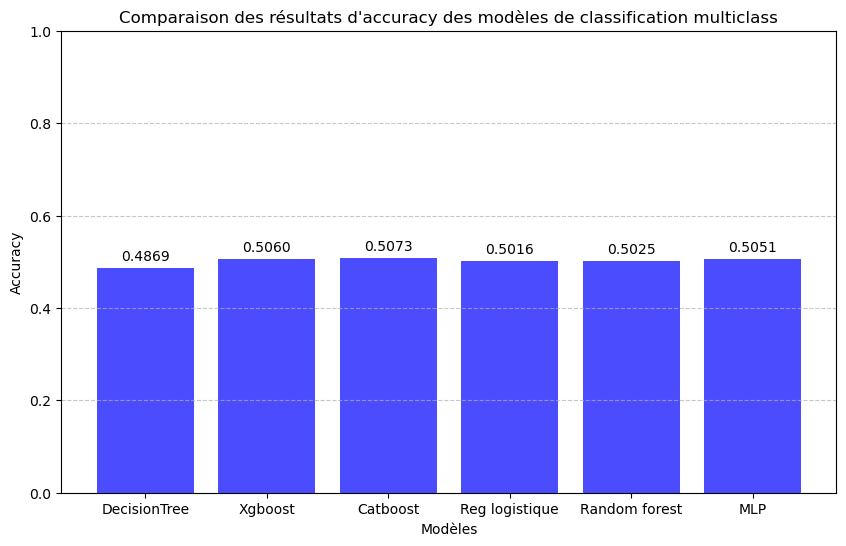

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Scores d'accuracy des différents modèles
accuracy_scores = [DescisionTree_score_multi, Xgboost_score_multi, catboost_score_multi, logisti_reg_score_multi, random_score_multi, mlp_multi] 

# Noms des modèles correspondants
model_names = ['DecisionTree', 'Xgboost', 'Catboost', 'Reg logistique', 'Random forest', 'MLP'] 

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color='blue', alpha=0.7)
plt.xlabel('Modèles')
plt.ylabel('Accuracy')
plt.title('Comparaison des résultats d\'accuracy des modèles de classification multiclass')
plt.ylim(0, 1)  # Assurez-vous que l'axe y va de 0 à 1 pour l'accuracy
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage des scores sur chaque barre
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Affichage de l'histogramme
plt.show()

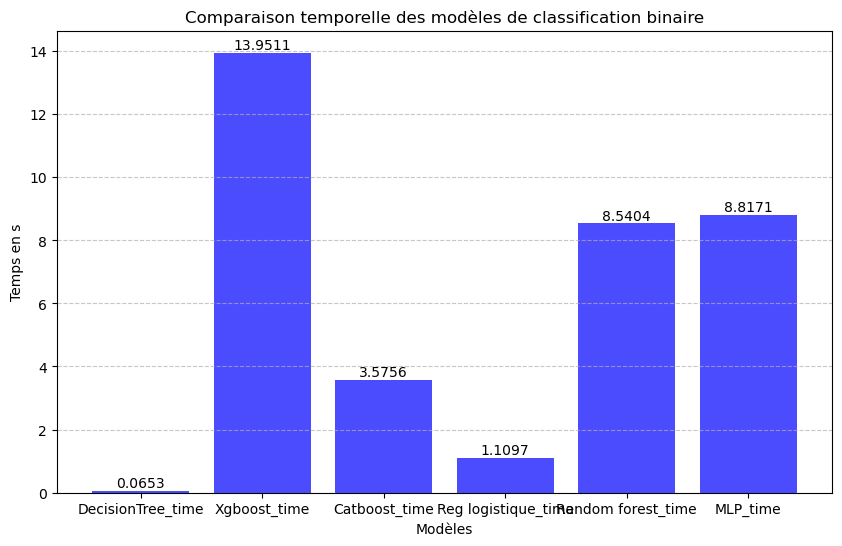

In [ ]:
Temps = [DecisionTree_time, Xgboost_time, CatBoost_time, Logisti_reg_time, Random_time, mlp_time] 

# Noms des modèles correspondants
model_names = ['DecisionTree_time', 'Xgboost_time', 'Catboost_time', 'Reg logistique_time', 'Random forest_time', 'MLP_time'] 

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(model_names, Temps, color='blue', alpha=0.7)
plt.xlabel('Modèles')
plt.ylabel('Temps en s')
plt.title('Comparaison temporelle des modèles de classification binaire')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(Temps):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# Affichage de l'histogramme
plt.show()